In [1]:
import os

import pandas as pd
import numpy as np

from dotenv import load_dotenv
from nixtlats import TimeGPT
from usageUtils import getUsageData
from IPython.display import Markdown

load_dotenv()

True

In [2]:
timegpt = TimeGPT(token=os.getenv("TIMEGPT_TOKEN"))

timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [3]:
# Get current API token usage data

getUsageData()

Current usage data:

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  150   ||   TOKENS:  517280   ||   SPENT:  861.19          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [4]:
# DATA PREP: Create dataframe from csv file, convert 'TimePeriod' column to timezone-naive datetime, remove uneccessary columns, save to csv file, create new dataframe from csv file, return new dataframe

def dataPrep(dfName, csvName, timeCol, dropCols, csvNameUpdate):
    dfName = pd.read_csv(csvName)
    dfName[timeCol] = pd.to_datetime(dfName[timeCol]).dt.tz_localize(None)
    dfName = dfName.drop(columns=dropCols)
    dfName.to_csv(csvNameUpdate, index=False)
    dfName = pd.read_csv(csvNameUpdate)
    return dfName

In [5]:
# Run dataPrep function on sample data

df = dataPrep(
    dfName="df",
    csvName="../data/raw/billing1_raw.csv",
    timeCol="TimePeriod",
    dropCols=["Tenant"],
    csvNameUpdate="../data/clean/billing1_clean.csv"
)

display(df.head())

,TimePeriod,ProratedQuantity
0,2023-09-08,1.167562e+06
1,2023-09-09,1.220100e+06
2,2023-09-10,1.184406e+06
3,2023-09-11,1.322509e+06
4,2023-09-12,1.330776e+06


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2023-10-09,0,1.418832e+06,1688277.875,1.957724e+06
1,2023-10-10,0,1.488189e+06,1757634.875,2.027081e+06
2,2023-10-11,0,1.495546e+06,1764991.250,2.034437e+06
3,2023-10-12,0,1.496953e+06,1766398.500,2.035844e+06
4,2023-10-13,0,1.468383e+06,1737828.750,2.007274e+06
...,...,...,...,...,...
142,2024-02-28,0,2.233362e+06,2502807.500,2.772253e+06
143,2024-02-29,0,2.233207e+06,2502652.250,2.772098e+06
144,2024-03-01,0,2.160278e+06,2429723.750,2.699169e+06
145,2024-03-02,0,1.944523e+06,2213968.250,2.483414e+06


### Detected Anomalies (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
87,2024-01-04,1,1.217690e+06,1487136.000,1.756582e+06
88,2024-01-05,1,1.197563e+06,1467008.625,1.736454e+06
103,2024-01-20,1,1.356944e+06,1626389.625,1.895835e+06
104,2024-01-21,1,1.250522e+06,1519967.250,1.789413e+06
129,2024-02-15,1,1.851312e+06,2120758.000,2.390204e+06


### Results Comparison Plot (Default 99% Prediction Interval Level)

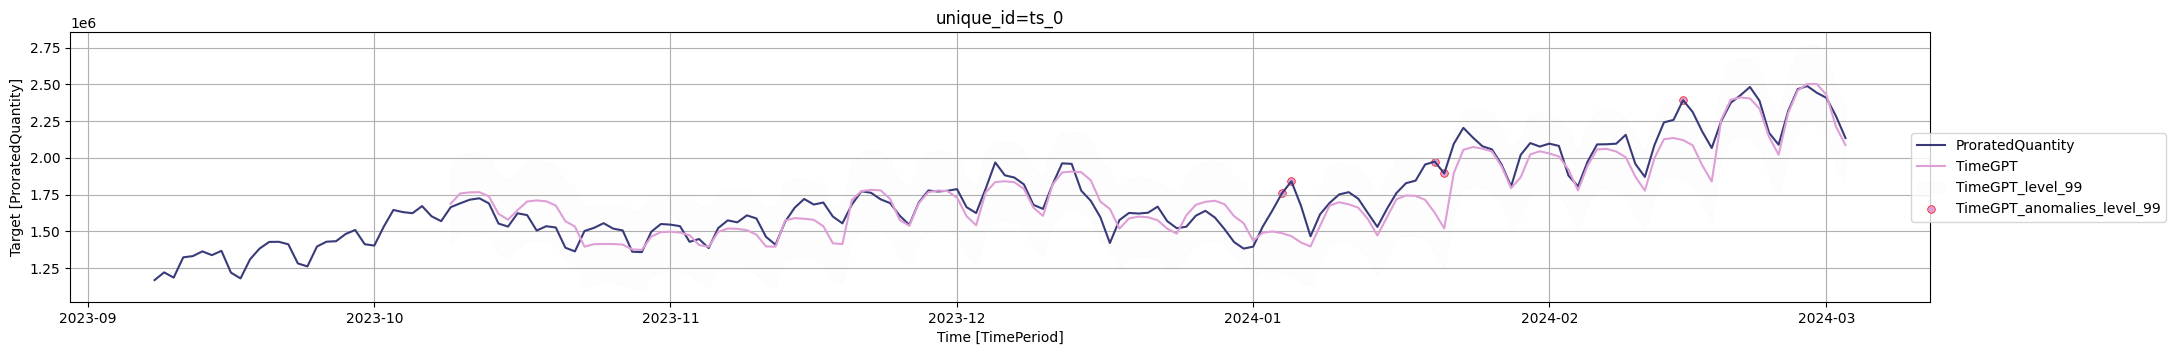

In [6]:
# Run anomaly detection model, plot results compared with original data (default prediction interval level is 99)

dfAnoms = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D"
)

dfAnomsOnly = dfAnoms[dfAnoms["anomaly"] == 1]

plotAnoms = timegpt.plot(
    df, dfAnoms, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (Default 99% Prediction Interval Level)"),
    dfAnoms,
    Markdown("### Detected Anomalies (Default 99% Prediction Interval Level)"),
    dfAnomsOnly,
    Markdown("### Results Comparison Plot (Default 99% Prediction Interval Level)"),
    plotAnoms,
)

In [7]:
# Get historical prediction intervals to test against detected anomalies

dfFcst = timegpt.forecast(
    df, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, level=[99, 90, 99.99],
)

dfFcst = dfFcst.merge(df)

for lv in [99, 90, 99.99]:
    dfFcst[f"anomaly_{lv}"] = (
        dfFcst["ProratedQuantity"] > dfFcst[f"TimeGPT-hi-{lv}"]
    ) | (
        dfFcst["ProratedQuantity"] < dfFcst[f"TimeGPT-lo-{lv}"]
    )

    dfFcst[f"anomaly_{lv}"] = dfFcst[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


In [8]:
# Test detected anomalies against historical prediction intervals defalut level 99

pd.testing.assert_series_equal(
    dfFcst["anomaly_99"],
    dfAnoms.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
0,2023-10-09,0,1.516217e+06,1688277.875,1.860338e+06
1,2023-10-10,0,1.585574e+06,1757634.875,1.929695e+06
2,2023-10-11,0,1.592931e+06,1764991.250,1.937052e+06
3,2023-10-12,0,1.594338e+06,1766398.500,1.938459e+06
4,2023-10-13,0,1.565768e+06,1737828.750,1.909889e+06
...,...,...,...,...,...
142,2024-02-28,0,2.330747e+06,2502807.500,2.674868e+06
143,2024-02-29,0,2.330592e+06,2502652.250,2.674713e+06
144,2024-03-01,0,2.257663e+06,2429723.750,2.601784e+06
145,2024-03-02,0,2.041908e+06,2213968.250,2.386029e+06


### Detected Anomalies (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
87,2024-01-04,1,1.217690e+06,1487136.000,1.756582e+06
88,2024-01-05,1,1.197563e+06,1467008.625,1.736454e+06
103,2024-01-20,1,1.356944e+06,1626389.625,1.895835e+06
104,2024-01-21,1,1.250522e+06,1519967.250,1.789413e+06
129,2024-02-15,1,1.851312e+06,2120758.000,2.390204e+06


### Results Comparison Plot (90% Prediction Interval Level)

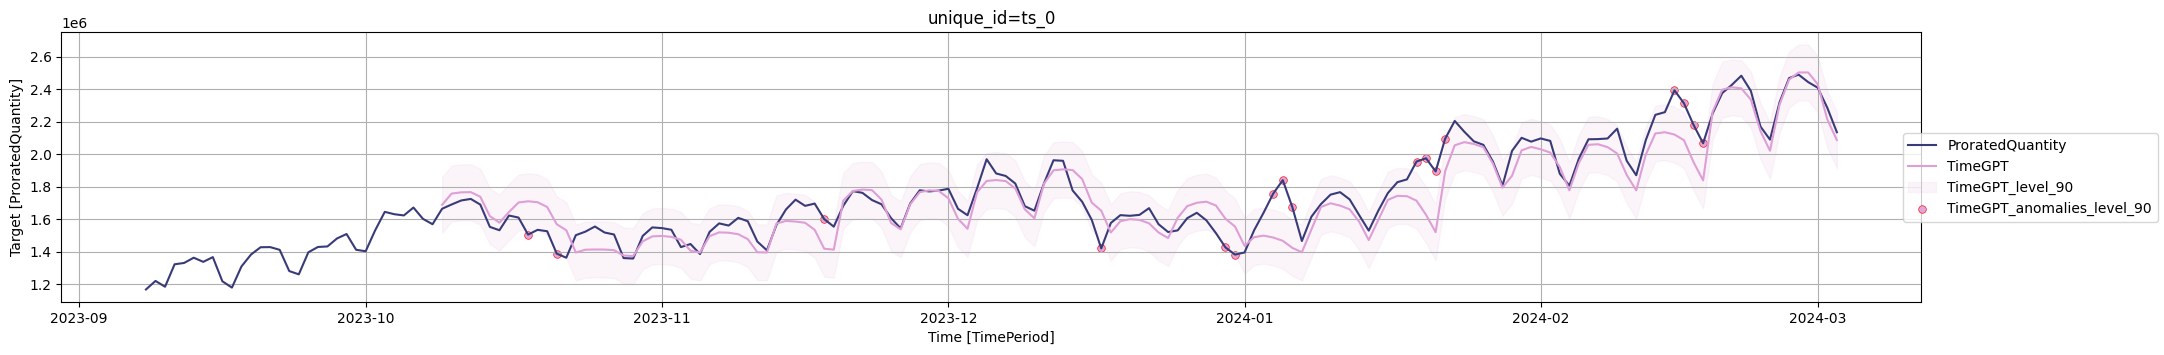

In [9]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 90 should identify more anomalies)

dfAnoms90 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=90
)

dfAnomsOnly90 = dfAnoms[dfAnoms["anomaly"] == 1]

plotAnoms90 = timegpt.plot(
    df, dfAnoms90, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (90% Prediction Interval Level)"),
    dfAnoms90,
    Markdown("### Detected Anomalies (90% Prediction Interval Level)"),
    dfAnomsOnly90,
    Markdown("### Results Comparison Plot (90% Prediction Interval Level)"),
    plotAnoms90,
)

In [10]:
# Test detected anomalies against historical prediction interval level 90

pd.testing.assert_series_equal(
    dfFcst["anomaly_90"],
    dfAnoms90.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2023-10-09,0,1.281301e+06,1688277.875,2.095255e+06
1,2023-10-10,0,1.350658e+06,1757634.875,2.164612e+06
2,2023-10-11,0,1.358014e+06,1764991.250,2.171968e+06
3,2023-10-12,0,1.359422e+06,1766398.500,2.173375e+06
4,2023-10-13,0,1.330852e+06,1737828.750,2.144806e+06
...,...,...,...,...,...
142,2024-02-28,0,2.095831e+06,2502807.500,2.909784e+06
143,2024-02-29,0,2.095675e+06,2502652.250,2.909629e+06
144,2024-03-01,0,2.022747e+06,2429723.750,2.836701e+06
145,2024-03-02,0,1.806991e+06,2213968.250,2.620945e+06


### Detected Anomalies (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99


### Results Comparison Plot (99.99% Prediction Interval Level)

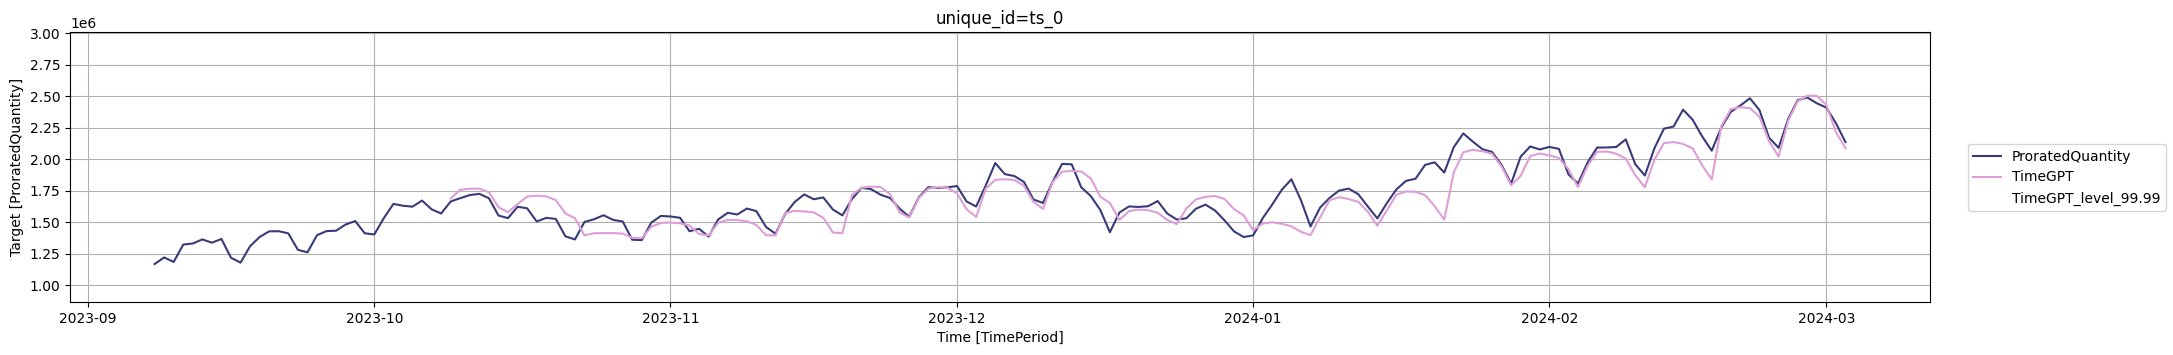

In [11]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

dfAnoms99_99 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=99.99,
)

dfAnomsOnly99_99 = dfAnoms99_99[dfAnoms99_99["anomaly"] == 1]

plotAnoms99_99 = timegpt.plot(
    df, dfAnoms99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level)"),
    dfAnoms99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level)"),
    dfAnomsOnly99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level)"),
    plotAnoms99_99,
)

In [12]:
# Test detected anomalies against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    dfFcst["anomaly_99.99"],
    dfAnoms99_99.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

In [13]:
# Get historical prediction intervals to test against detected anomalies with exogenous variables

dfFcstX = timegpt.forecast(
    df, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, date_features=True, level=[99, 90, 99.99],
)

dfFcstX = dfFcstX.merge(df)

for lv in [99, 90, 99.99]:
    dfFcstX[f"anomaly_{lv}"] = (
        dfFcstX["ProratedQuantity"] > dfFcstX[f"TimeGPT-hi-{lv}"]
    ) | (
        dfFcstX["ProratedQuantity"] < dfFcstX[f"TimeGPT-lo-{lv}"]
    )

    dfFcstX[f"anomaly_{lv}"] = dfFcstX[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: year_2023, year_2024, month_1, month_2, month_3, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...
INFO:nixtlats.timegpt:Using the following exogenous variables: year_2023, year_2024, month_1, month_2, month_3, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6


### Anomalies Detection Result (99.99% Prediction Interval Level with Exogeneous Variables)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2023-10-09,0,1.305223e+06,1.701976e+06,2.098729e+06
1,2023-10-10,0,1.371348e+06,1.768101e+06,2.164854e+06
2,2023-10-11,0,1.379074e+06,1.775827e+06,2.172580e+06
3,2023-10-12,0,1.370964e+06,1.767717e+06,2.164470e+06
4,2023-10-13,0,1.340459e+06,1.737212e+06,2.133965e+06
...,...,...,...,...,...
142,2024-02-28,0,2.111405e+06,2.508158e+06,2.904911e+06
143,2024-02-29,0,2.105716e+06,2.502469e+06,2.899222e+06
144,2024-03-01,0,2.029535e+06,2.426288e+06,2.823041e+06
145,2024-03-02,0,1.820125e+06,2.216878e+06,2.613631e+06


### Detected Anomalies (99.99% Prediction Interval Level with Exogeneous Variables)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99


### Results Comparison Plot (99.99% Prediction Interval Level with Exogeneous Variables)

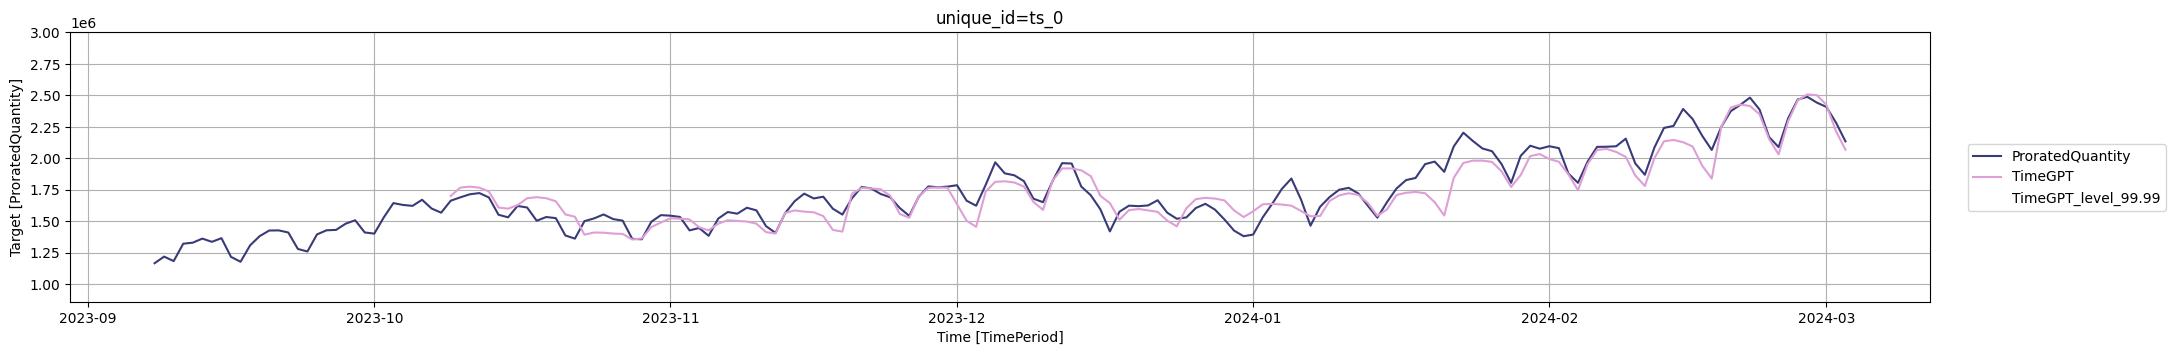

In [14]:
# Run anomaly detection model with exogeneous variables, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

dfAnomsX99_99 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", date_features=True, level=99.99,
)

dfAnomsOnlyX99_99 = dfAnomsX99_99[dfAnomsX99_99["anomaly"] == 1]

plotAnomsX99_99 = timegpt.plot(
    df, dfAnomsX99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level with Exogeneous Variables)"),
    dfAnomsX99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level with Exogeneous Variables)"),
    dfAnomsOnlyX99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level with Exogeneous Variables)"),
    plotAnomsX99_99,
)

In [15]:
# Test detected anomalies with exogeneous variables against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    dfFcstX["TimeGPT-lo-99.99"],
    dfAnomsX99_99.merge(df)["TimeGPT-lo-99.99"],
    check_index=False,
    check_names=False,
    rtol=1,
    atol=1,
)

In [16]:
# Get updated API token usage data

getUsageData(update=True)

Usage data successfully updated with: 4 . . . . .
<<  2 calls  ••  19046 tokens  ••  26.67 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  158   ||   TOKENS:  549202   ||   SPENT:  910.12          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
